<a href="https://colab.research.google.com/github/armarmarm927/dl_lecture_competition_pub/blob/main/sparkproto3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch import optim
import torch.nn.init as init
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset,DataLoader
from torch.optim import lr_scheduler
import torchvision.datasets as dsets
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
batch_size = 100
train_data = dsets.CIFAR10(root='./tmp/cifar-10',train=True,download=True,transform=transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),transforms.RandomCrop(32, padding=(4, 4, 4, 4), padding_mode='constant'),transforms.ToTensor(),transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),transforms.RandomErasing(p=0.5,scale=(0.02,0.33),ratio=(0.3,3.3),value=0,inplace=False)]))
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_data = dsets.CIFAR10(root='./tmp/cifar-10',train=False,download=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])]))
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model_ft = models.resnet50(pretrained=True)
model_ft.fc = nn.Linear(model_ft.fc.in_features,10)
net = model_ft.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
criterion =nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.1,momentum=0.9,weight_decay=0.00005)
scheduler = lr_scheduler.LambdaLR(optimizer,lr_lambda=lambda epoch:0.95**epoch)

In [6]:
loss, epoch_loss, count = 0, 0, 0
acc_list = []
loss_list = []

for i in range(50):
    net.train()
    for j, data in enumerate(train_loader, 0):
        optimizer.zero_grad()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        count += 1

    print('%depoch: mean_loss: %.3f' % (i+1, epoch_loss/count))
    loss_list.append(epoch_loss/count)
    epoch_loss = 0
    count = 0
    correct = 0
    total = 0
    accuracy = 0.0

    # 混同行列用のリスト
    y_true = []
    y_pred = []

    net.eval()
    with torch.no_grad():
        for j, data in enumerate(test_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # 混同行列用データ保存
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100. * correct / total
    acc_list.append(accuracy)
    print('epoch:%d Accuracy(%d/%d): %.2f%%' % (i+1, correct, total, accuracy))

    # 混同行列の計算と表示
    cm = confusion_matrix(y_true, y_pred)
    print(f'Confusion Matrix (Epoch {i+1}):')
    print(cm)

    torch.save(net.state_dict(), 'Weight' + str(i+1))
    scheduler.step()


1epoch: mean_loss: 2.752
epoch:1 Accuracy(1000/10000): 10.00%
Confusion Matrix (Epoch 1):
[[   0    0  999    1    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]]
2epoch: mean_loss: 2.307
epoch:2 Accuracy(1000/10000): 10.00%
Confusion Matrix (Epoch 2):
[[   1    0    0    0    0  999    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]
 [   0    0    0    0    0 1000    0    0    0    0]
 [   1    0    0    0   

In [7]:
print(acc_list)

[10.0, 10.0, 9.99, 25.69, 32.29, 37.4, 44.43, 48.92, 53.62, 54.7, 58.76, 61.49, 56.09, 63.44, 64.75, 65.78, 68.27, 68.99, 69.44, 73.01, 62.19, 62.06, 67.4, 70.59, 72.01, 73.14, 73.38, 74.37, 75.27, 75.7, 75.39, 76.56, 77.4, 76.94, 77.26, 77.63, 77.84, 78.13, 79.12, 78.93, 79.67, 79.17, 79.54, 79.91, 80.3, 76.07, 78.93, 78.72, 79.32, 79.83]


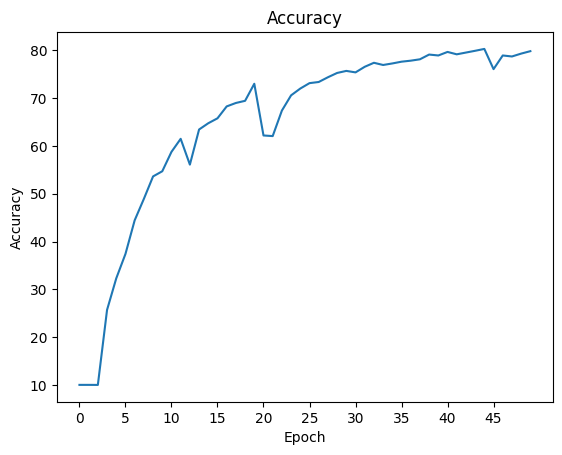

In [9]:
plt.plot(acc_list)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,50,5))
plt.ylabel('Accuracy')
plt.show()